Processing...
Done!
Estimated accuracy:80.24%
Best accuracy:90.24%


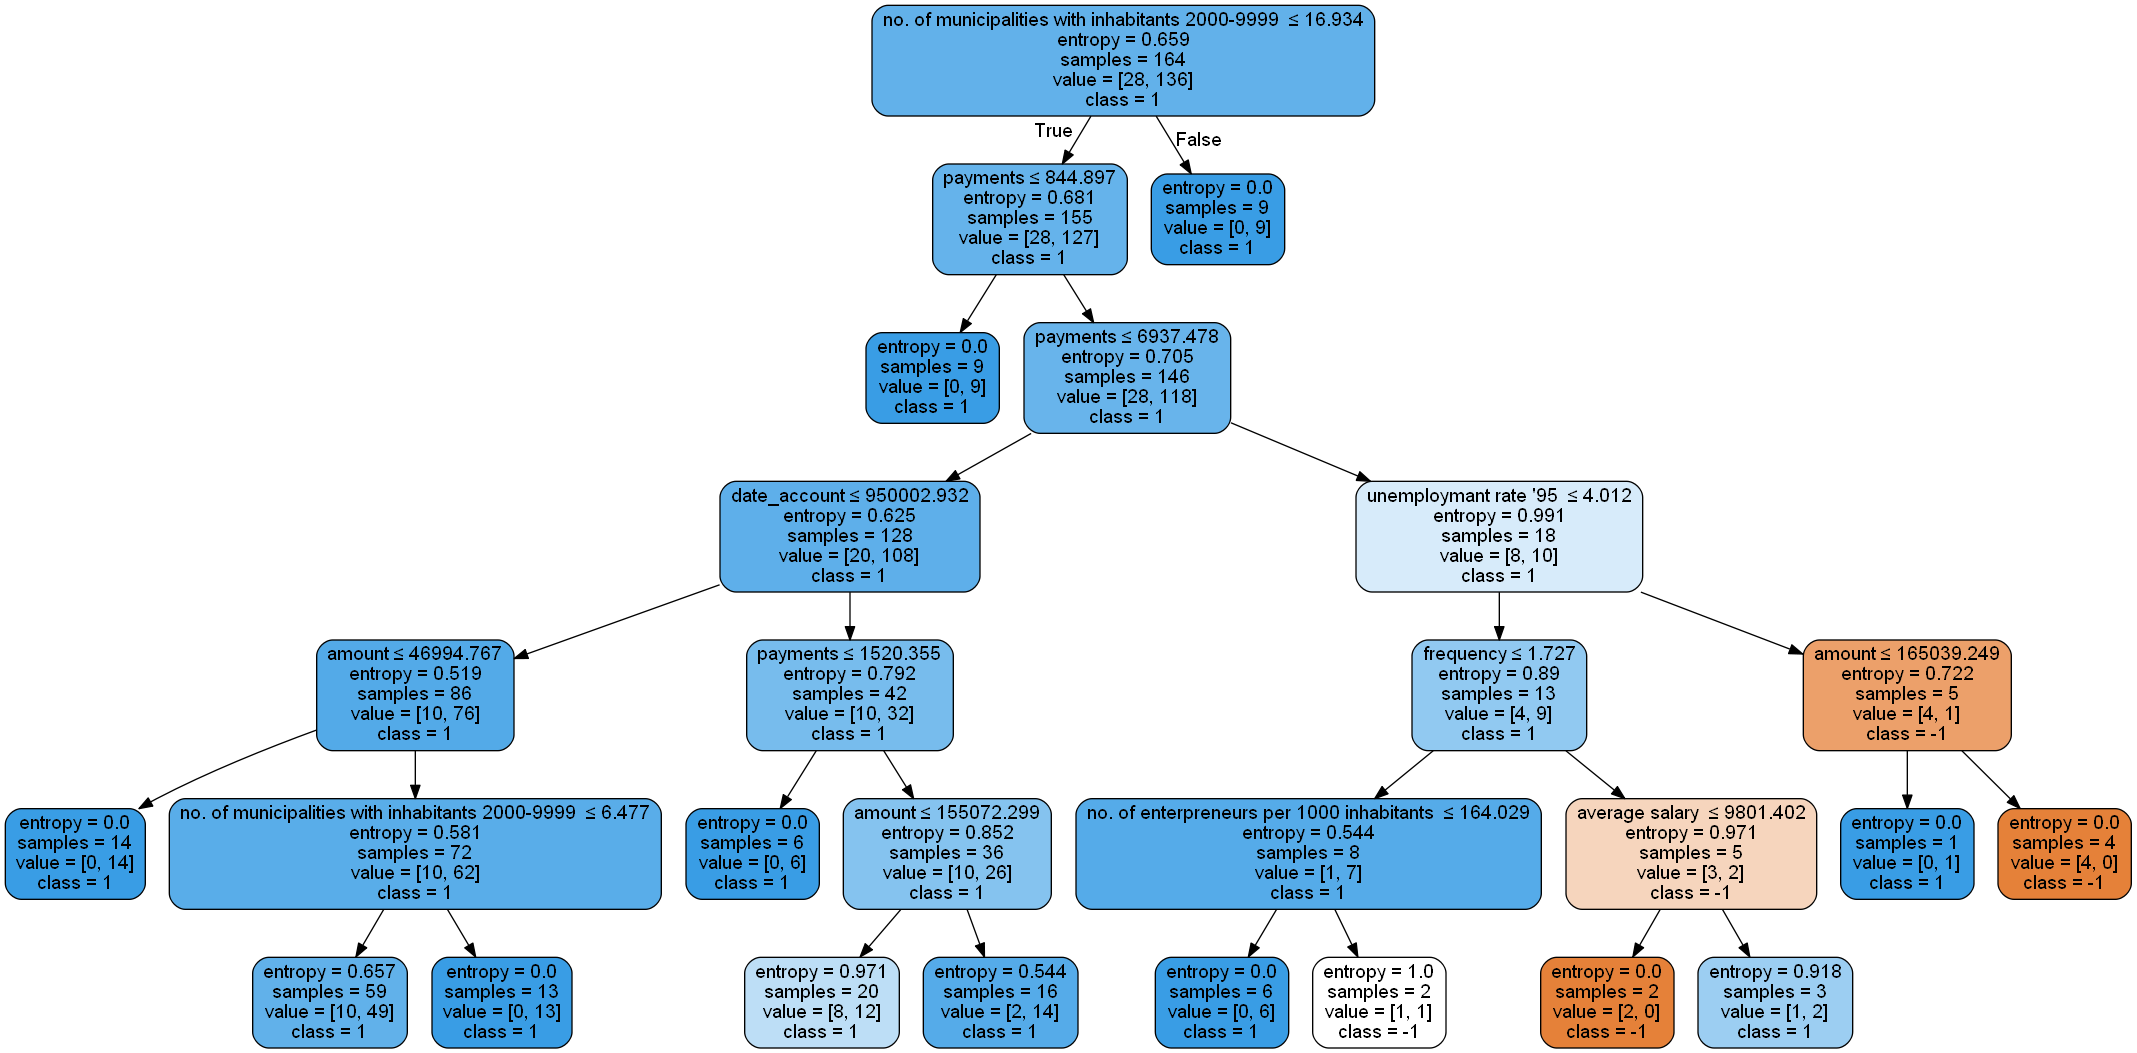

In [49]:
import pandas as pd, numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import os
cwd = os.path.abspath(os.getcwd())

loan_file_path = cwd + '/assets/loan_train.csv'
account_file_path = cwd + '/assets/account.csv'
district_file_path = cwd + '/assets/district.csv'
#client_file_path = cwd + '/assets/client.csv'
#disp_file_path = cwd + '/assets/disp.csv'

loan_data = pd.read_csv(loan_file_path, sep=";")
account_data = pd.read_csv(account_file_path, sep=";")
district_data = pd.read_csv(district_file_path, sep=";")
#client_data = pd.read_csv(client_file_path, sep=";")
#disp_data = pd.read_csv(disp_file_path, sep=";")

final_data = account_data.merge(loan_data, on='account_id', suffixes=['_account','_loan'])
final_data = district_data.merge(final_data, left_on='code ', right_on='district_id')

predict_data = final_data
predict_data = predict_data.drop(columns=['account_id', 'code ', 'name ', 'region', 'loan_id'])
predict_data['unemploymant rate \'95 '] = np.where(predict_data['unemploymant rate \'95 '] == '?', predict_data['unemploymant rate \'96 '], predict_data['unemploymant rate \'95 '])
predict_data['unemploymant rate \'95 '] = pd.to_numeric(predict_data['unemploymant rate \'95 '], errors='coerce')
predict_data['no. of commited crimes \'95 '] = np.where(predict_data['no. of commited crimes \'95 '] == '?', predict_data['no. of commited crimes \'96 '], predict_data['no. of commited crimes \'95 '])
predict_data['no. of commited crimes \'95 '] = pd.to_numeric(predict_data['no. of commited crimes \'95 '], errors='coerce')
d = {'issuance after transaction': 0, 'monthly issuance': 1, 'weekly issuance': 2 }
predict_data['frequency'] = predict_data['frequency'].map(d)

average_score = 0
n_test = 2000
best_score = 0

print('Processing...')
for x in range(n_test):

    predict_data = predict_data.sample(frac=1)
    train_data = np.array_split(predict_data, 2)[0]
    test_data = np.array_split(predict_data, 2)[1]

    y = train_data.status
    x = train_data.drop(columns=['status'])

    dtree = DecisionTreeClassifier(criterion="entropy", splitter="random", max_depth=6)
    dtree = dtree.fit(x,y)
    y_pred = dtree.predict(test_data.drop(columns=['status']))
    y_test = test_data.status

    cur_score = accuracy_score(y_test, y_pred)
    
    average_score += cur_score
    
    if cur_score > best_score:
        btree = dtree
        best_score = cur_score


average_score /= n_test


print(f'Done!\nEstimated accuracy:{average_score:.2%}')
print(f'Best accuracy:{best_score:.2%}')

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(btree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = test_data.drop(columns=['status']).columns,class_names=['-1','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('result.png')
Image(graph.create_png())
